In [1]:
import numpy as np
import pandas as pd
import re
import ast

import matplotlib.pyplot as plt

In [2]:
# Change the file path for the file movie.metadata.tsv
file_path = "data/movie.metadata.tsv"

In [3]:
# Reading the file into a pandas dataframe
movie_summaries = pd.read_csv(file_path, sep="\t", header=None)
movie_summaries.columns = ["Wikipedia movie ID",
 "Freebase_movie_ID",
 "Movie_name",
 "Movie_release_date",
 "Movie_box_office_revenue",
 "Movie_runtime",
 "Movie_languages",
 "Movie_countries",
 "Movie_genres"]
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Remove prefix '/m/'
movie_summaries['Freebase_movie_ID'] = movie_summaries['Freebase_movie_ID'].str.replace('/m/', '')

In [5]:
# Create new columns for languages, countries and genres
# The data type of the new columns is list containing all possible values
# Only take the values into account for now,
# If we need the code for further analysis, just apply x.keys() instead of x.values()

movie_summaries['Movie_languages_clean'] = movie_summaries['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_countries_clean'] = movie_summaries['Movie_countries'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_genres_clean'] = movie_summaries['Movie_genres'].apply(ast.literal_eval).apply(lambda x: list(x.values()))

In [6]:
# Extract the release year
# This column only contains the years
movie_summaries['Movie_release_year'] = movie_summaries['Movie_release_date'].str.extract(r'(\d{4})')

# Convert strings to datetime values if there are
# For the rows with only years, the value is replaced by NaT
# pd.to_datetime has a bug if the format provided is more "precise" than what is in the dataframe, it has default values and will not 
# raise an error or replace with NaT
# specifically %Y-%m-%d with year 2000 defaults to 2000-01-01, even with the exact=True argument.

movie_summaries['Movie_release_date_datetime'] = movie_summaries['Movie_release_date'].astype('str').apply(
        lambda x: pd.to_datetime(x if "-" in x else pd.NaT, errors="coerce")
)

In [7]:
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT


In [8]:
display(movie_summaries['Movie_release_year'].dropna().max())
display(movie_summaries['Movie_release_year'].dropna().min())

'2016'

'1010'

In [9]:
import requests
from bs4 import BeautifulSoup

In [10]:
def getData(year):
    url = f'https://www.boxofficemojo.com/year/{year}/?sortDir=asc&sort=rank&grossesOption=totalGrosses'

    # Send a GET request to the URL
    response = requests.get(url)

    df = pd.DataFrame()
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract relevant information (modify this based on the structure of the webpage)
        # Example: Extracting movie titles
        df['movie_title'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-left mojo-field-type-release mojo-cell-wide')]
        df['movie_revenue'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-right mojo-field-type-money mojo-estimatable')]

        
    return df

In [11]:
# Uncomment if you need to re-write the data from the website

# df_all = pd.DataFrame()

# Python range is not inclusive for the second value
# for i in range(1977, 2024):
#    temp = getData(i)
#    df_all = pd.concat([df_all, temp], ignore_index=True)
  
# Write to csv
# df_all.to_csv('data/mojo_data.csv', header=None, index=False)

In [12]:
# Reading the file into a pandas dataframe
df_all = pd.read_csv('data/mojo_data.csv', header=None)
df_all.columns = ["movie_title",
 "movie_revenue"]
df_all.head()


,movie_title,movie_revenue
0,Star Wars: Episode IV - A New Hope,"$307,263,857"
1,Smokey and the Bandit,"$126,737,428"
2,Close Encounters of the Third Kind,"$116,395,460"
3,Saturday Night Fever,"$94,213,184"
4,A Bridge Too Far,"$50,750,000"


In [13]:
# We can just always consider the original dataset, and replace the missing revenues with the ones from the Mojo dateset

# Drop duplicate movies, based on name only
df_all = df_all.drop_duplicates(subset=['movie_title'])
movie_summaries = movie_summaries.drop_duplicates(subset=['Movie_name'])
# Merge dataframes based on the movie name, left join so we keep all of the original data
merged_df = pd.merge(movie_summaries, df_all, right_on='movie_title', left_on='Movie_name', how='left')

# Drop the extra column (either 'movie_title' or 'Movie_name') if needed
# merged_df = merged_df.drop('movie_title', axis=1)

# Cleaning up the revenues

# Remove the dollar sign and commas
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')

# Convert the column to floats
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(float)

# Create a boolean mask for rows where movie_revenue is NaN and gross_revenue is not NaN
mask = (pd.isna(merged_df['Movie_box_office_revenue'])) & (~pd.isna(merged_df['movie_revenue']))

# Replace missing values in Movie_box_office_revenue with movie_revenue 
merged_df.loc[mask, 'Movie_box_office_revenue'] = merged_df.loc[mask, 'movie_revenue']



# Tests to make sure it works as intended
# test = merged_df.copy(deep=True)
# test.loc[mask, 'Movie_box_office_revenue'] = test.loc[mask, 'movie_revenue']
# mask = (pd.isna(test['Movie_box_office_revenue'])) & (~pd.isna(test['movie_revenue']))
# result = test[mask]
# print(result.shape)

# print(merged_df[pd.isna(merged_df['Movie_box_office_revenue'])].shape)
# print(test[pd.isna(test['Movie_box_office_revenue'])].shape)

C:\Users\fifko\AppData\Local\Temp\ipykernel_5268\2566794732.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')


In [14]:
display(merged_df.loc[merged_df['Movie_name'] == 'Coming to America'])
# There are some differences in revenue in the two datasets, but we just keep the original dataset value in that case


,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue
75441,54540,0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",1988,1988-06-29,Coming to America,128152301.0


The language that makes the most money is English Language with a total revenue of $375,440,608,931.0


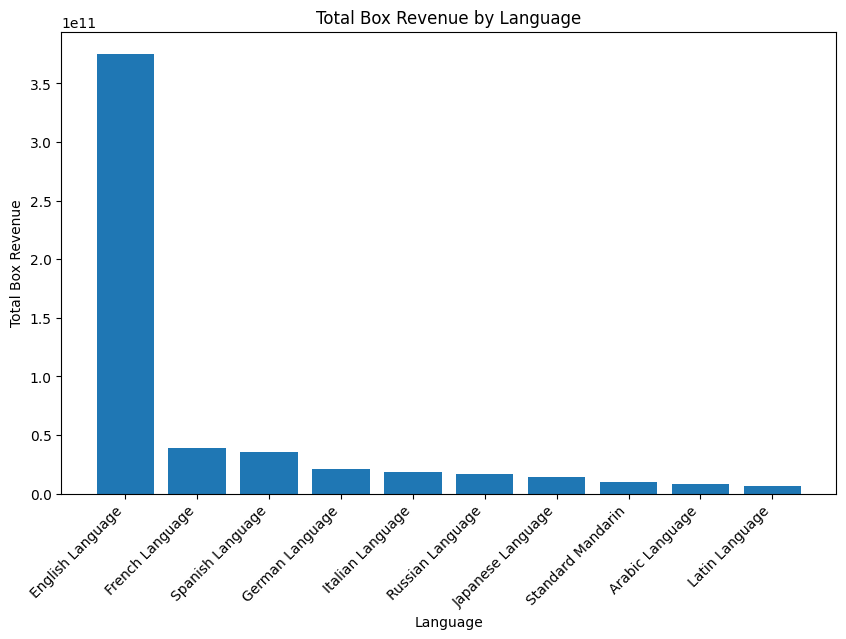

In [15]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].sum().reset_index()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_revenue['Movie_languages_clean'][:10], language_revenue['Movie_box_office_revenue'][:10])
plt.xlabel('Language')
plt.ylabel('Total Box Revenue')
plt.title('Total Box Revenue by Language')
plt.xticks(rotation=45, ha='right')

language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)
top_language = language_revenue.iloc[0]['Movie_languages_clean']
top_revenue = language_revenue.iloc[0]['Movie_box_office_revenue']
print(f"The language that makes the most money is {top_language} with a total revenue of ${top_revenue:,}")

The language with the highest average revenue per movie is Old English language with an average revenue of $747,456,792.33


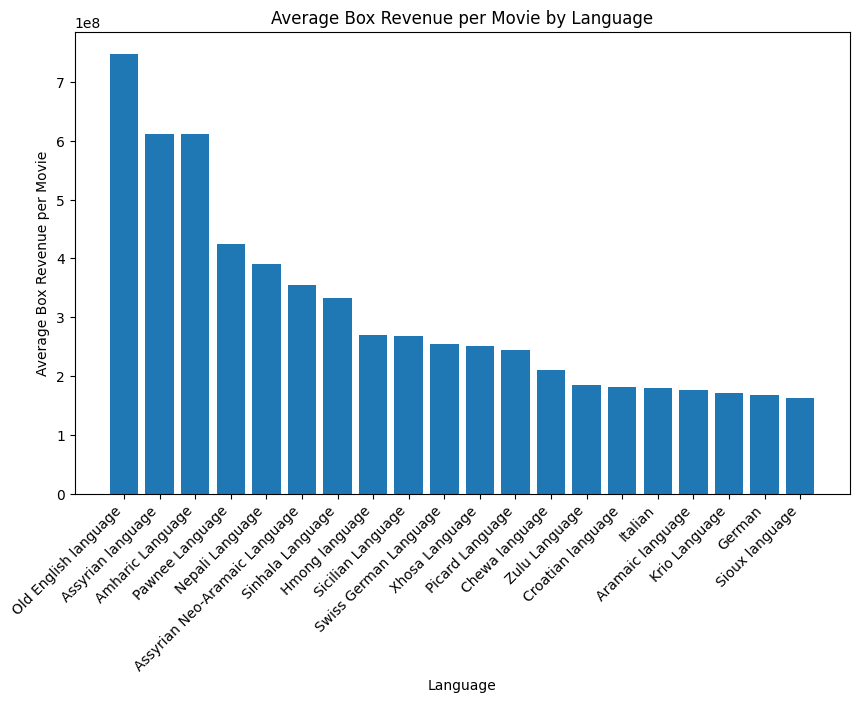

In [16]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_stats.index[:20], language_stats['average_revenue_per_movie'][:20])
plt.xlabel('Language')
plt.ylabel('Average Box Revenue per Movie')
plt.title('Average Box Revenue per Movie by Language')
plt.xticks(rotation=45, ha='right')

top_language = language_stats.index[0]
top_average_revenue = language_stats['average_revenue_per_movie'].iloc[0]
print(f"The language with the highest average revenue per movie is {top_language} with an average revenue of ${top_average_revenue:,.2f}")

In [17]:
# Movies that used Old English
test = df_language.explode('Movie_languages_clean')
display(test.loc[test['Movie_languages_clean'] == 'Old English language'])

,Freebase_movie_ID,Movie_name,Movie_box_office_revenue,Movie_languages_clean
8707,017gm7,The Lord of the Rings: The Two Towers,9.260471e+08,Old English language
57200,07nxnw,Beowulf,1.963937e+08,Old English language
74769,017jd9,The Lord of the Rings: The Return of the King,1.119930e+09,Old English language


In [18]:
import statsmodels.api as sm

df_reg = merged_df[['Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_reg = df_reg.explode('Movie_languages_clean', ignore_index=True)
df_reg = df_reg.dropna(subset=['Movie_languages_clean'])

df_reg['Movie_languages_clean'] = df_reg['Movie_languages_clean'].apply(lambda x: x.encode('utf-8', 'replace').decode('utf-8'))

# The languages are transformed into columns representing 0 or 1 for whether the movie contains the language
df_reg = pd.get_dummies(df_reg, columns=['Movie_languages_clean'], prefix='', prefix_sep='')




df_reg = df_reg.dropna()

# Perform linear regression
X = df_reg.drop(['Movie_name', 'Movie_box_office_revenue'], axis=1)  # Features = all languages
y = df_reg['Movie_box_office_revenue']  # y = revenue

# Add a constant to the features (required for statsmodels) since we're not using an explicit formula
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.030
Method:                       Least Squares   F-statistic:                     3.470
Date:                      Thu, 16 Nov 2023   Prob (F-statistic):           4.07e-40
Time:                              15:30:26   Log-Likelihood:            -2.3330e+05
No. Observations:                     11680   AIC:                         4.669e+05
Df Residuals:                         11533   BIC:                         4.680e+05
Df Model:                               146                                         
Covariance Type:                  nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

The P-values are too high, we cannot conclude that the language in isolation has an impact on the box office revenue of a movie